# **Sunspots prediction in time series with Keras LSTM model**

# **Import Libraries**

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# **Load dataset**

In [3]:
df=pd.read_csv('/content/Sunspots .csv')

In [4]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


# **Exploratory Data Analysis(EDA)**

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
time=df['Unnamed: 0'].values
series=df['Monthly Mean Total Sunspot Number'].values

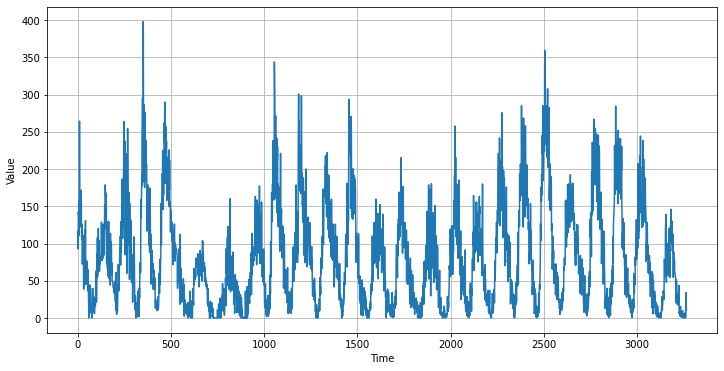

In [8]:
plt.figure(figsize=(12,6))
plot_series(time,series)

# **Model Training**

# **Using simple DNN**

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):          
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

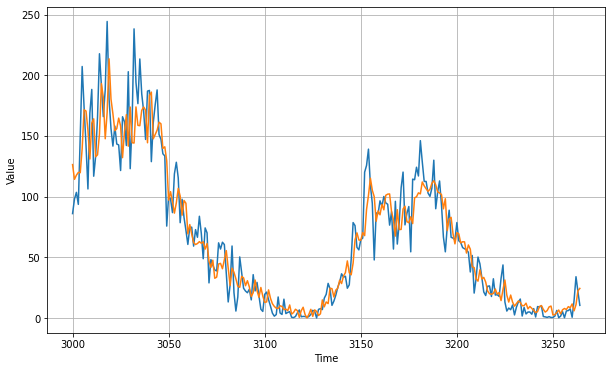

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.801179

**Conclusion-**
* **very large MAE** so something must be wrong.we can see that the seasonality of sunspots is far greater than two years. It's closer to 11 years. And actually some science tells us that it might even be 22 years with different cycles interleaguing with each other. So let's  **retrain with a window size of 132, which is 11 years worth of data as our window size.**


In [ ]:
time=df['Unnamed: 0'].values
series=df['Monthly Mean Total Sunspot Number'].values

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 132
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

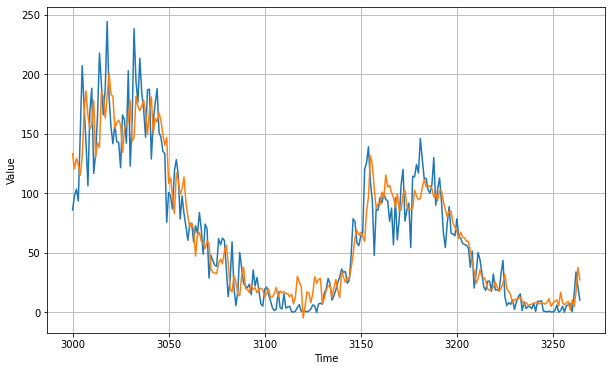

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.2953615

**Conclusion-**
* we can see from the MAE that it actually does not decrease much so increasing the window size didn't work.

* Well, by looking back to the data, we can realize that it is seasonal to about 11 years, but we don't need a full season in our window.

* So maybe we don't need a huge window of time in order to train. Maybe we should go with something a little bit more like our initial 20, let's try 30.

# **Trying Simple DNN with windowsize=30**

In [9]:
time=df['Unnamed: 0'].values
series=df['Monthly Mean Total Sunspot Number'].values

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):          
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

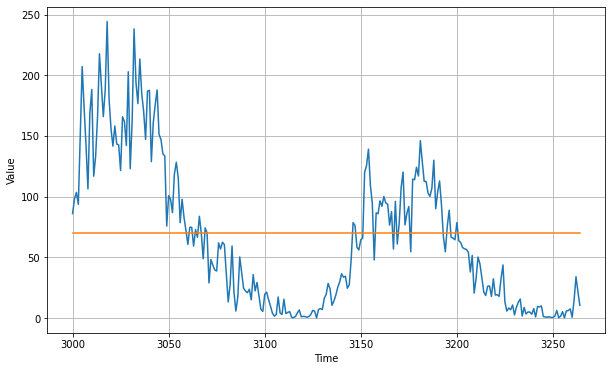

In [13]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

50.18049

# **Using LSTM and Conv1D**

In [ ]:
time=df['Unnamed: 0'].values
series=df['Monthly Mean Total Sunspot Number'].values

In [ ]:
series

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)                            # Expanding dimension of series ie making it a 2D array
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# **Finding optimal LearningRate**

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
93/93 [==============================] - 7s 36ms/step - loss: 74.3419 - mae: 74.8404
Epoch 2/100
93/93 [==============================] - 3s 36ms/step - loss: 54.2656 - mae: 54.7633
Epoch 3/100
93/93 [==============================] - 3s 36ms/step - loss: 44.8308 - mae: 45.3268
Epoch 4/100
93/93 [==============================] - 3s 36ms/step - loss: 39.2612 - mae: 39.7569
Epoch 5/100
93/93 [==============================] - 3s 36ms/step - loss: 36.8461 - mae: 37.3423
Epoch 6/100
93/93 [==============================] - 3s 36ms/step - loss: 34.7821 - mae: 35.2782
Epoch 7/100
93/93 [==============================] - 3s 36ms/step - loss: 33.3284 - mae: 33.8258
Epoch 8/100
93/93 [==============================] - 4s 37ms/step - loss: 31.9307 - mae: 32.4266
Epoch 9/100
93/93 [==============================] - 3s 36ms/step - loss: 29.4075 - mae: 29.9029
Epoch 10/100
93/93 [==============================] - 4s 37ms/step - loss: 28.9086 - mae: 29.4027
Epoch 11/100
93/93 [=========

(1e-08, 0.0001, 0.0, 60.0)

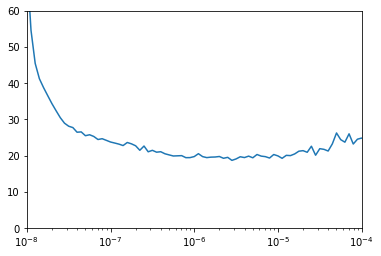

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

**Setting Learning Rate** =1e-5

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

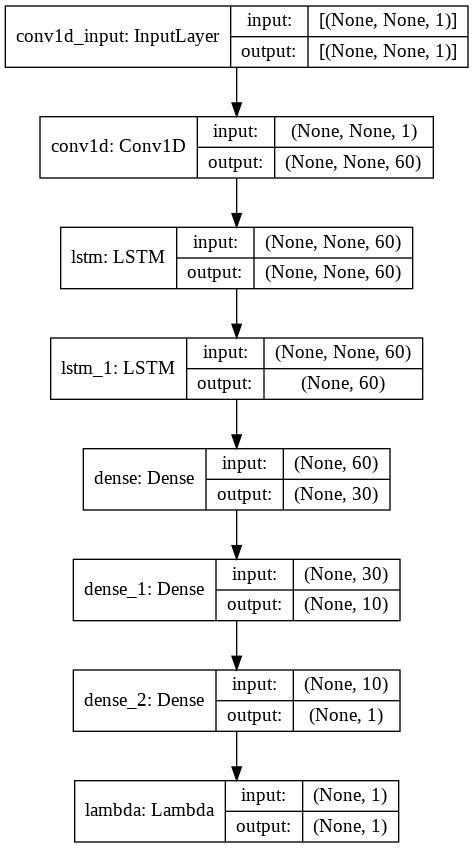

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
history = model.fit(train_set,epochs=500)

Epoch 1/500
93/93 [==============================] - 7s 35ms/step - loss: 35.3595 - mae: 35.8550
Epoch 2/500
93/93 [==============================] - 3s 36ms/step - loss: 25.4295 - mae: 25.9232
Epoch 3/500
93/93 [==============================] - 3s 35ms/step - loss: 22.7539 - mae: 23.2471
Epoch 4/500
93/93 [==============================] - 3s 35ms/step - loss: 19.2426 - mae: 19.7336
Epoch 5/500
93/93 [==============================] - 3s 36ms/step - loss: 19.9993 - mae: 20.4937
Epoch 6/500
93/93 [==============================] - 3s 35ms/step - loss: 20.0875 - mae: 20.5804
Epoch 7/500
93/93 [==============================] - 3s 35ms/step - loss: 18.6887 - mae: 19.1821
Epoch 8/500
93/93 [==============================] - 3s 35ms/step - loss: 18.8586 - mae: 19.3507
Epoch 9/500
93/93 [==============================] - 3s 35ms/step - loss: 18.8559 - mae: 19.3469
Epoch 10/500
93/93 [==============================] - 3s 35ms/step - loss: 19.5898 - mae: 20.0824
Epoch 11/500
93/93 [=========

In [ ]:
model.save('sunspots.h5')

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,0]

In [ ]:
rnn_forecast.shape

(265,)

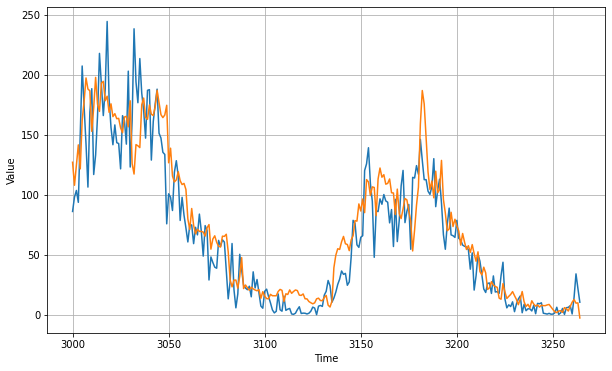

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
x_valid.shape

(265,)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17.545855

<Figure size 432x288 with 0 Axes>

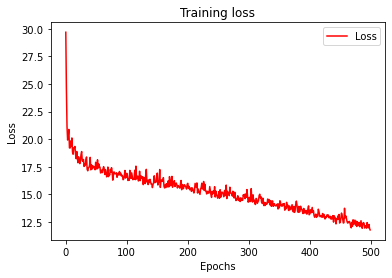

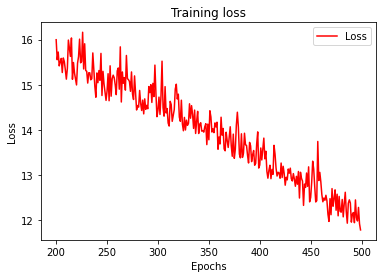

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[126.99227   107.82145   124.648056  141.48656   121.49362   161.89642
 177.73009   197.24986   187.99133   186.58382   152.72127   172.61617
 197.71126   175.36377   169.34755   192.92381   194.37082   178.27744
 182.02664   168.60771   175.67155   165.01038   167.48424   163.28094
 163.58438   155.65598   151.61725   164.6992    165.2507    156.51445
 178.22928   125.82649   117.17555   141.71954   140.73201   139.2101
 174.87851   180.48933   164.3934    162.75786   174.73804   166.97227
 165.94536   173.00647   186.92519   177.01688   166.65147   164.20071
 166.39851   174.47523   126.5514    138.72662   115.49983   110.57258
 112.372444  119.12227   111.61327   108.42484   109.37992   104.280235
  79.751144   70.98376    88.460205   74.50571    67.35953    71.123566
  69.38455    69.37819    68.842354   65.49475    72.3639     75.070694
  54.59563    63.040985   65.72175    60.287537   56.994884   56.401802
  65.41901    65.24075    67.01516    52.45212    29.049217   23.182642
  

In [19]:
d={'Model':['DNN','DNN','DNN','CONV_LSTM'],
'Window_Size':[60,132,30,30],
'Batch_Size':[32,32,32,32],
'MAE_on_Validationset':[13.80,15.29,50.18,17.54]}

In [20]:
summary=pd.DataFrame(d)

In [21]:
summary

,Model,Window_Size,Batch_Size,MAE_on_Validationset
0,DNN,60,32,13.80
1,DNN,132,32,15.29
2,DNN,30,32,50.18
3,CONV_LSTM,30,32,17.54


**Note**-**For batch_size=64, the loss and accuracy training results look better, but the MAE for the testing results are even worse.**